In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import random
from PIL import Image
import os
from tqdm import tqdm

from utils.utils_DataVisualization import check_images, show_images
from utils.utils_DataVisualization import compare_rgb_means_per_class, compare_rgb_meanVariances_per_class, compute_pixelwise_stats, show_number_image, compare_rgb_stats_per_class

path_to_data_folder = "../data"
path_to_cinic10 = f"{path_to_data_folder}/CINIC-10"

In [2]:
df = pd.read_csv(f"{path_to_data_folder}/cinic10_domain_labels.csv")
df.head()

,split,category,filename,source,full_path
0,train,airplane,cifar10-train-10008.png,CIFAR-10,train/airplane/cifar10-train-10008.png
1,train,airplane,cifar10-train-10010.png,CIFAR-10,train/airplane/cifar10-train-10010.png
2,train,airplane,cifar10-train-10020.png,CIFAR-10,train/airplane/cifar10-train-10020.png
3,train,airplane,cifar10-train-10024.png,CIFAR-10,train/airplane/cifar10-train-10024.png
4,train,airplane,cifar10-train-10050.png,CIFAR-10,train/airplane/cifar10-train-10050.png


In [3]:
print("Split Distribution:")
print(df["split"].value_counts().sort_index())
print()
print("Class (Category) Distribution:")
print(df["category"].value_counts().sort_index())
print()
print("Source Domain Distribution:")
print(df["source"].value_counts())

Split Distribution:
split
test     90000
train    90000
valid    90000
Name: count, dtype: int64

Class (Category) Distribution:
category
airplane      27000
automobile    27000
bird          27000
cat           27000
deer          27000
dog           27000
frog          27000
horse         27000
ship          27000
truck         27000
Name: count, dtype: int64

Source Domain Distribution:
source
ImageNet    210000
CIFAR-10     60000
Name: count, dtype: int64


In [4]:
print("Class-wise Domain Breakdown:")
pd.crosstab(df['category'], df['source'])

Class-wise Domain Breakdown:


source,CIFAR-10,ImageNet
category,,
airplane,6000,21000
automobile,6000,21000
bird,6000,21000
cat,6000,21000
deer,6000,21000
dog,6000,21000
frog,6000,21000
horse,6000,21000
ship,6000,21000


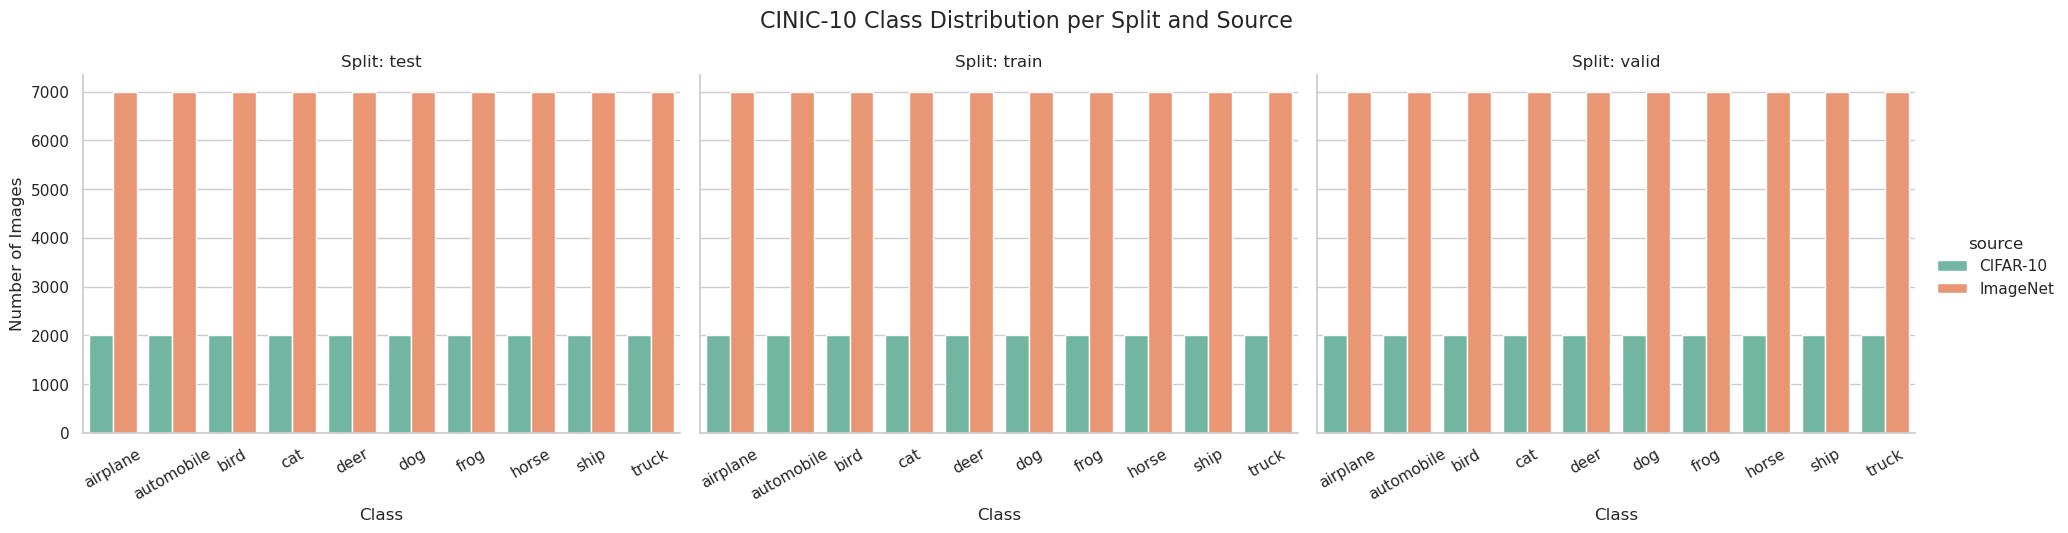

In [5]:
# Group by category, split, and source
grouped = df.groupby(["category", "split", "source"]).size().reset_index(name="count")

# Plot using seaborn
sns.set(style="whitegrid")
g = sns.catplot(
    data=grouped,
    x="category",
    y="count",
    hue="source",
    col="split",
    kind="bar",
    height=5,
    aspect=1.3,
    palette="Set2"
)
# Rotate x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)

g.set_axis_labels("Class", "Number of Images")
g.set_titles("Split: {col_name}")
plt.subplots_adjust(top=0.85)
plt.suptitle("CINIC-10 Class Distribution per Split and Source", fontsize=16)
plt.show()
# Save to file
g.savefig("../results/cinic10_class_distribution.pdf")

In [6]:
# brokenImagePaths = check_images(df, path_to_cinic10)

In [7]:
print("Duplicates:", df["full_path"].duplicated().sum())

Duplicates: 0


In [8]:
#print("Mean R,G,B Values per class")
#print("Description: Compute Mean per image, per color channel, per class and take the mean of all mean values per color channel, per class")
#compare_rgb_means_per_class(df, path_to_cinic10, n=6000) # Maximum value is 21000. Higher values to not change anything due to not having more pictures per class per source

In [9]:
#print("Mean R,G,B Variance Values per class")
#print("Description: Compute Variance per image, per color channel, per class and take the mean of all variances per color channel, per class")
#compare_rgb_meanVariances_per_class(df, path_to_cinic10, n=6000) # Maximum value is 21000. Higher values to not change anything due to not having more pictures per class per source

Computing RGB stats per class: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.64s/it]


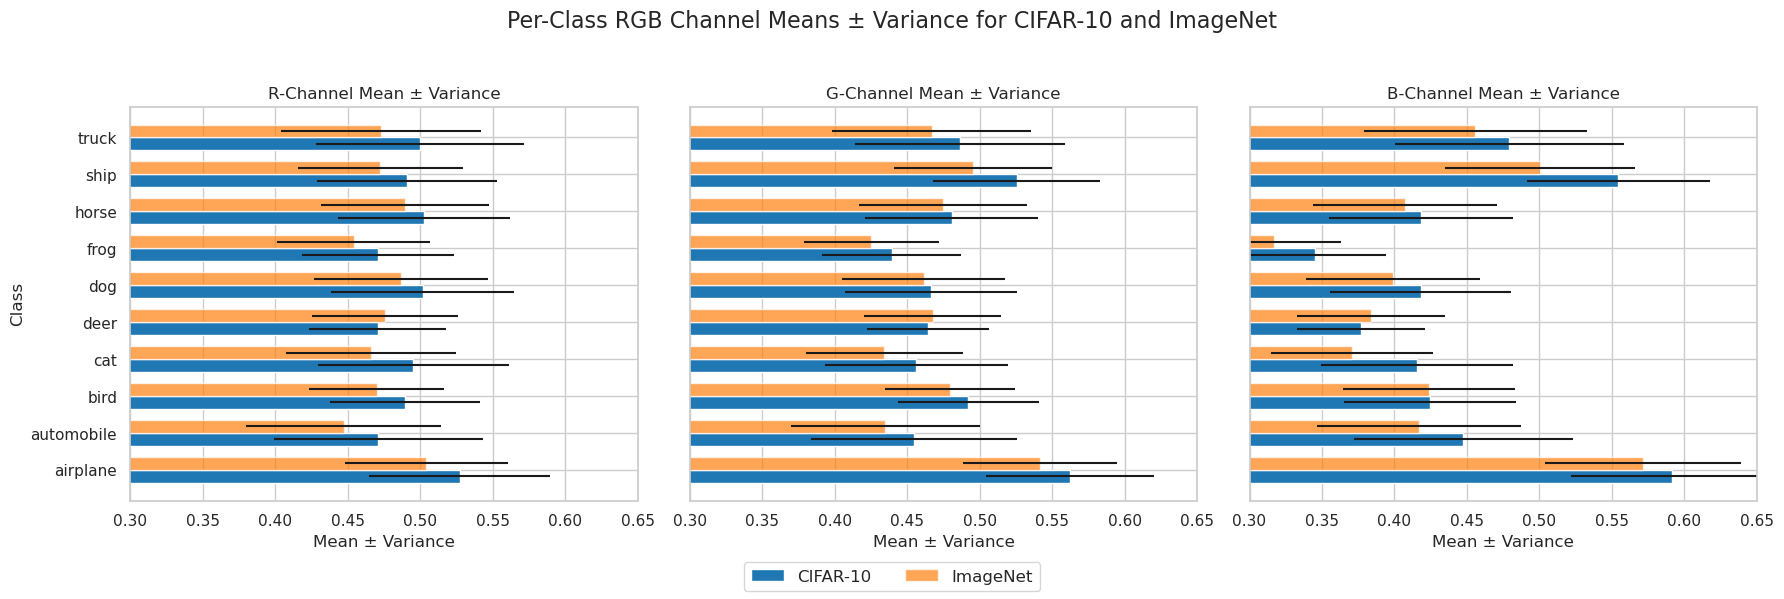

In [14]:
# Assuming this is the DataFrame returned from compare_rgb_means_per_class
df_rgb = compare_rgb_stats_per_class(df, path_to_cinic10, n=6000)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
colors = ['#1f77b4', '#ff7f0e']
channels = ['r', 'g', 'b']  # lowercase keys in df column names

for i, channel in enumerate(channels):
    ax = axes[i]
    y = np.arange(len(df_rgb["class"]))
    width = 0.35

    # Plot CIFAR-10
    ax.barh(y - width/2,
            df_rgb[f"cifar_{channel}"],
            height=width,
            xerr=df_rgb[f"cifar_var_{channel}"],
            label="CIFAR-10",
            color=colors[0])

    # Plot ImageNet
    ax.barh(y + width/2,
            df_rgb[f"imagenet_{channel}"],
            height=width,
            xerr=df_rgb[f"imagenet_var_{channel}"],
            label="ImageNet",
            color=colors[1],
            alpha=0.7)

    ax.set_title(f"{channel.upper()}-Channel Mean ± Variance")
    ax.set_xlabel("Mean ± Variance")
    ax.set_yticks(y)
    ax.set_yticklabels(df_rgb["class"])
    ax.set_xlim(0.3, 0.65)

axes[0].set_ylabel("Class")
fig.suptitle("Per-Class RGB Channel Means ± Variance for CIFAR-10 and ImageNet", fontsize=16)
fig.legend(["CIFAR-10", "ImageNet"], loc="lower center", ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig("../results/rgb_means_variance_per_class.pdf")
plt.show()

In [11]:
category = "airplane"
channel = "B"
numberOfSamples = 5000

cifar_mean_img, cifar_variance_img = compute_pixelwise_stats(df, path_to_cinic10, n=numberOfSamples, category=category, source="CIFAR-10")
imagenet_mean_img, imagenet_variance_img = compute_pixelwise_stats(df, path_to_cinic10, n=numberOfSamples, category=category, source="ImageNet")

mean_diff = imagenet_mean_img - cifar_mean_img
variance_diff = imagenet_variance_img - cifar_variance_img

Computing variance ['airplane'] | CIFAR-10: 5000it [00:01, 2981.22it/s]
Computing variance ['airplane'] | ImageNet: 5000it [00:02, 1859.00it/s]


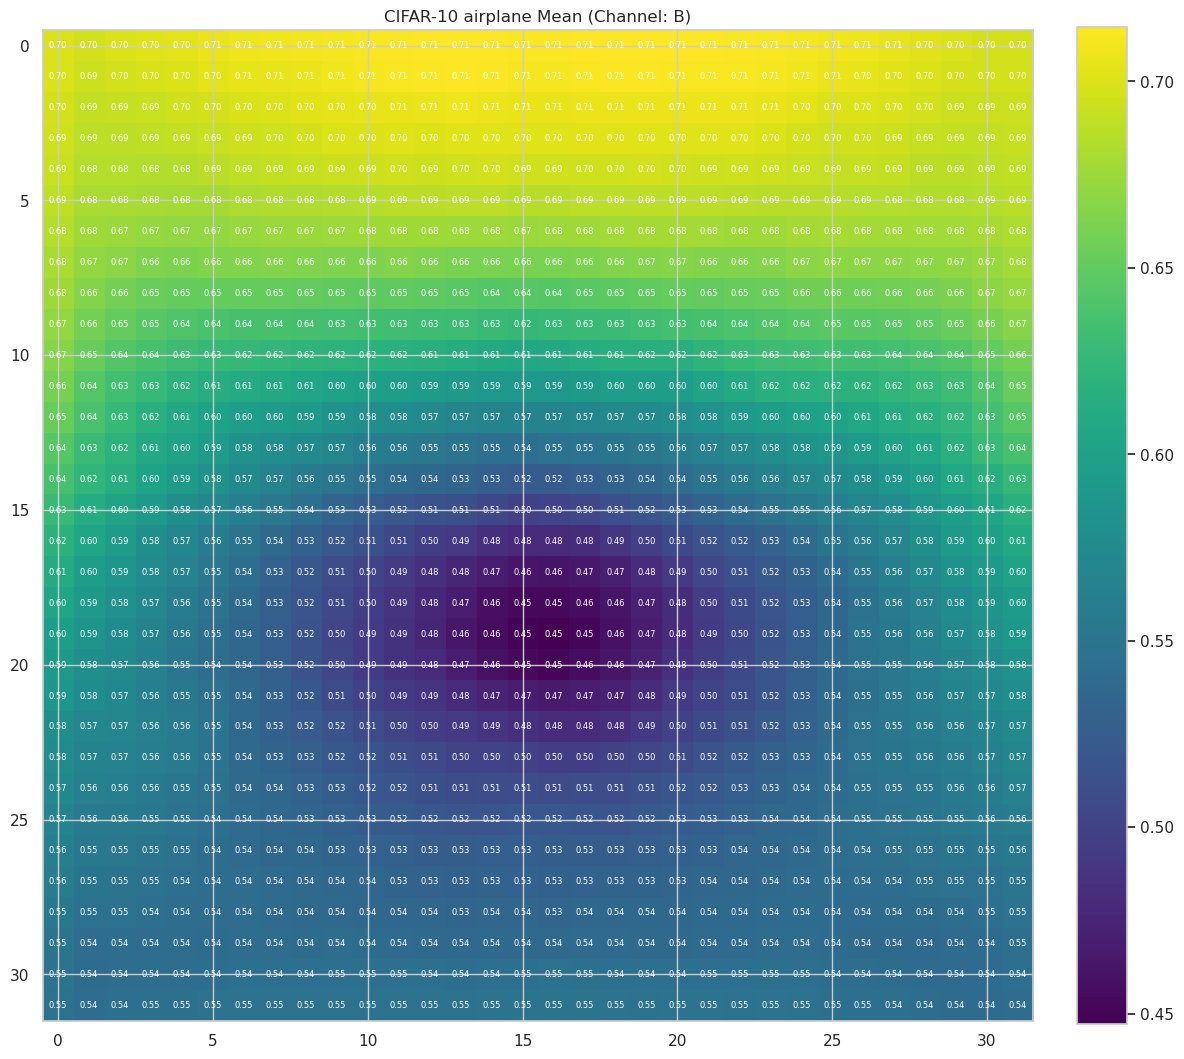

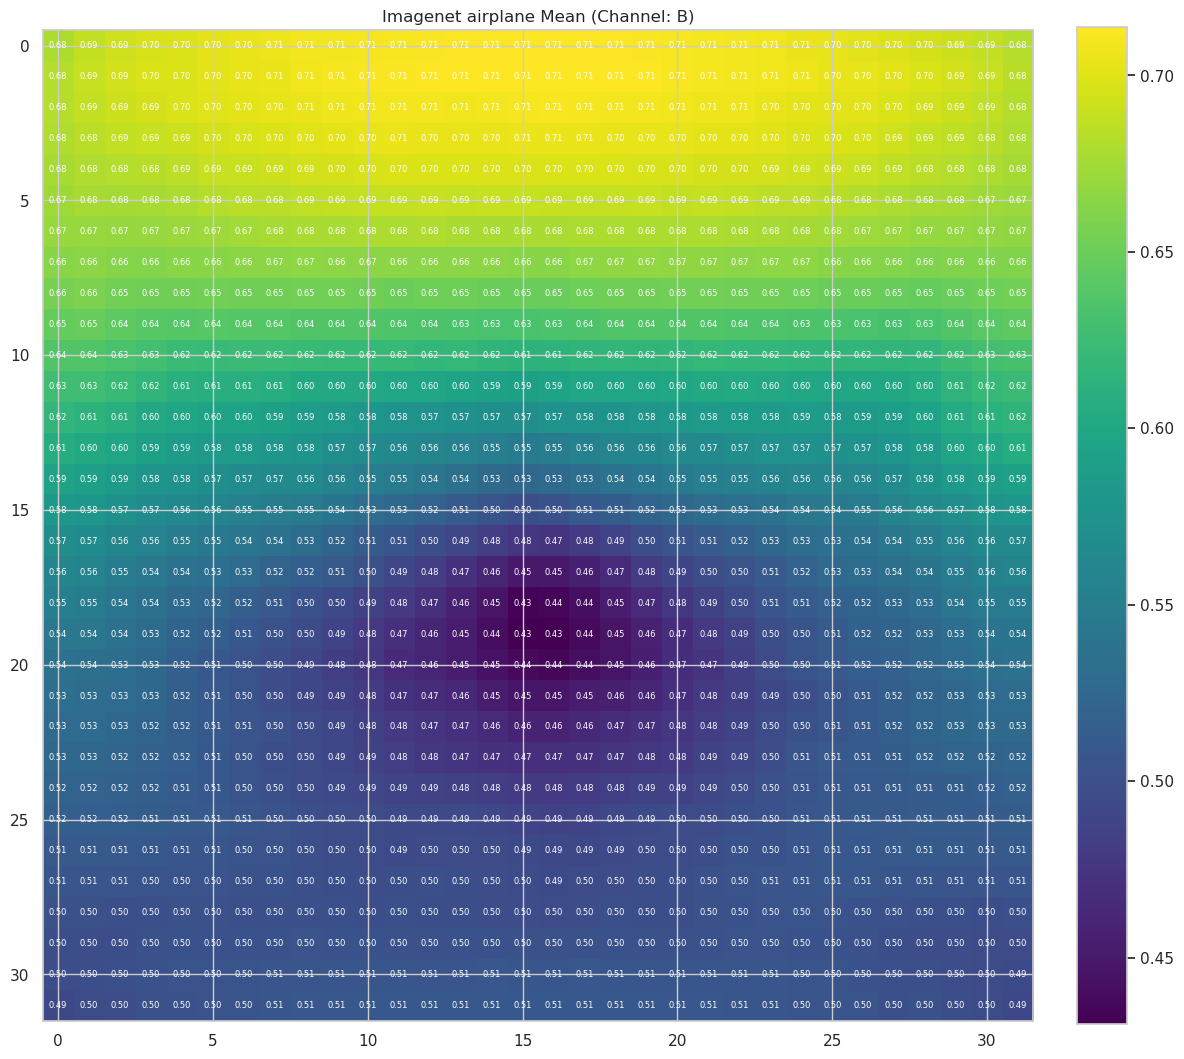

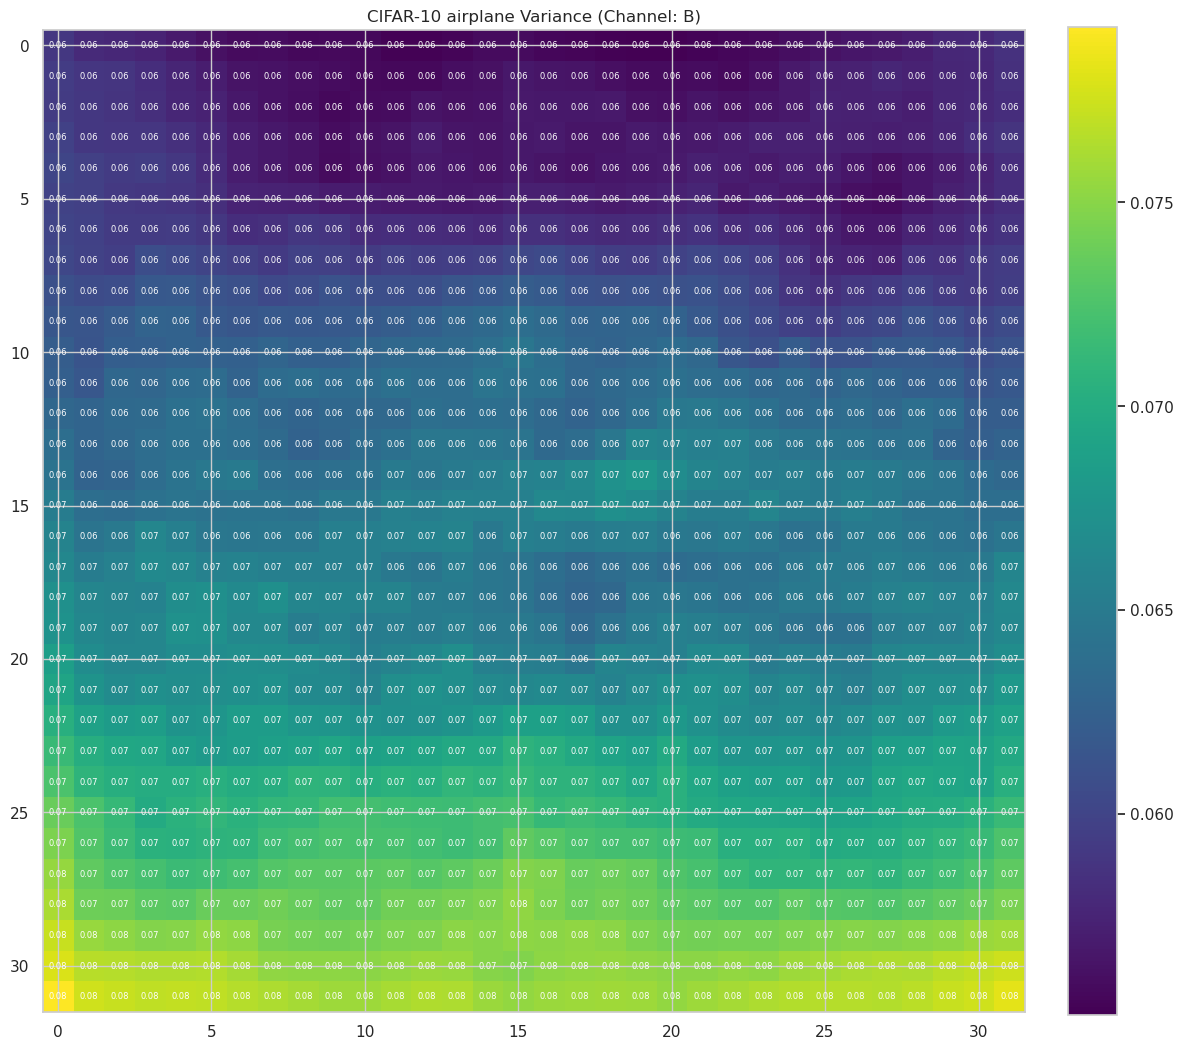

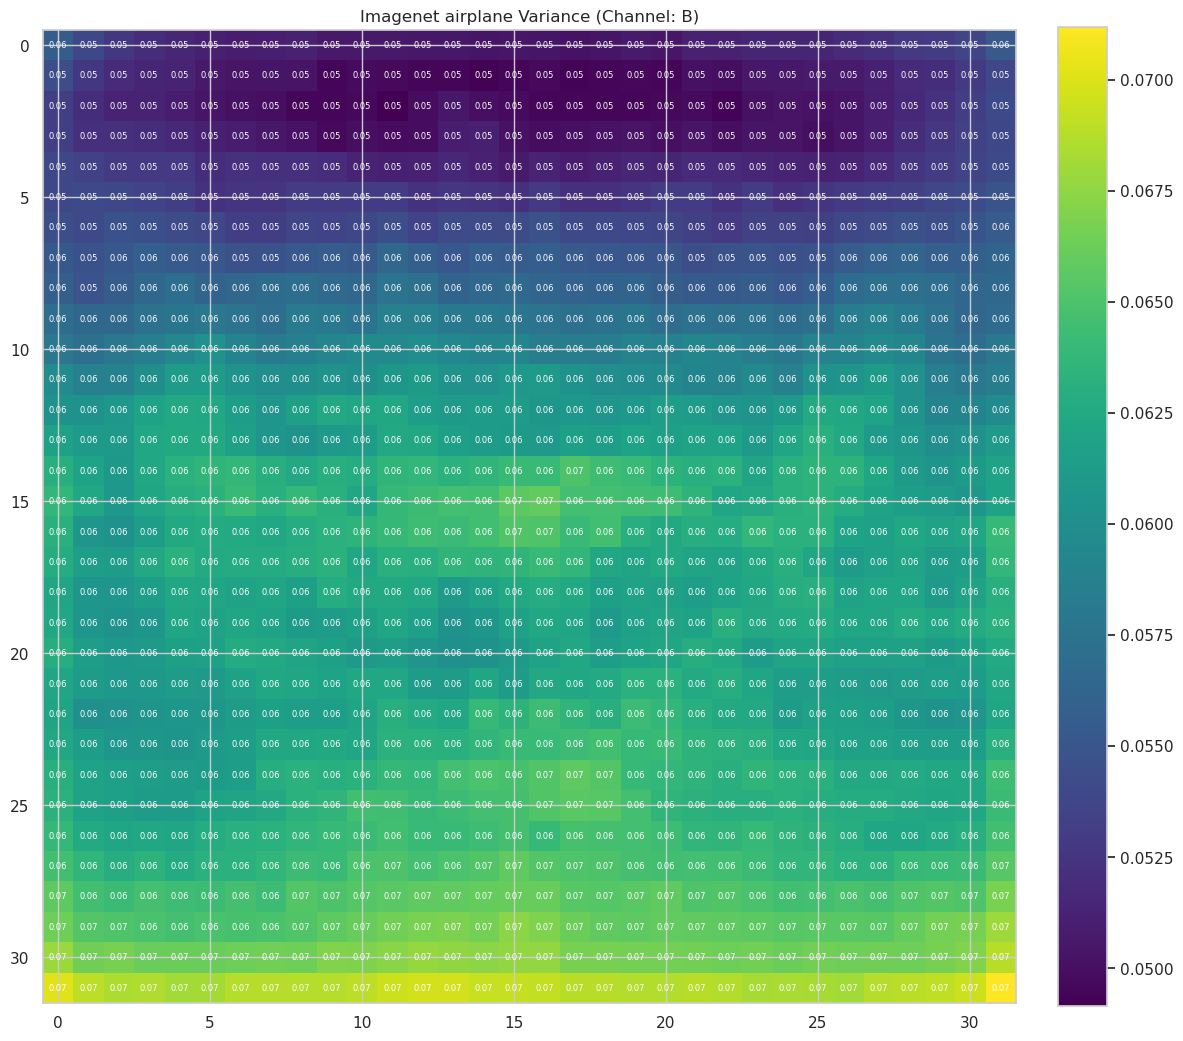

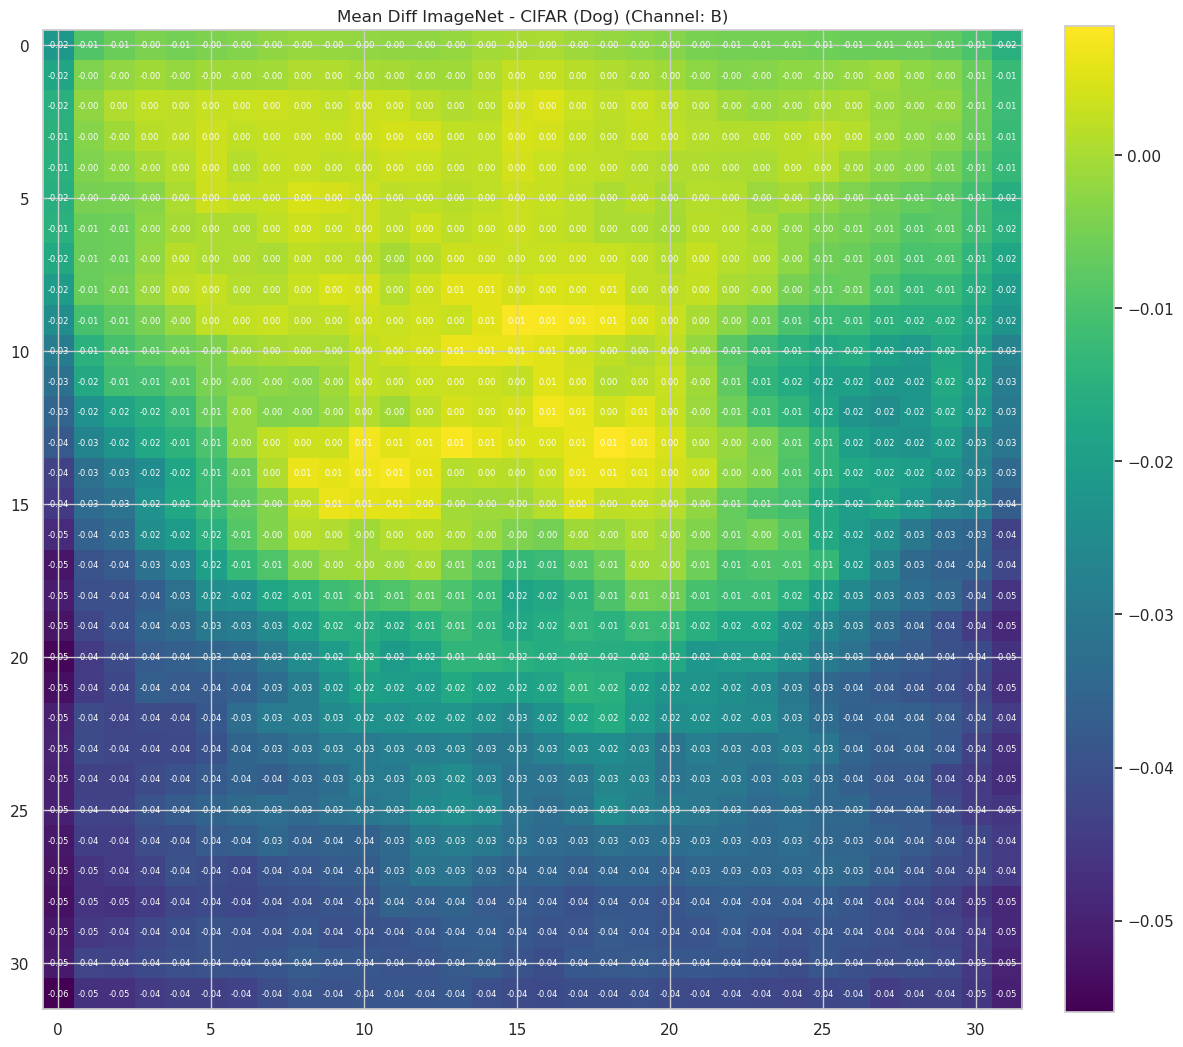

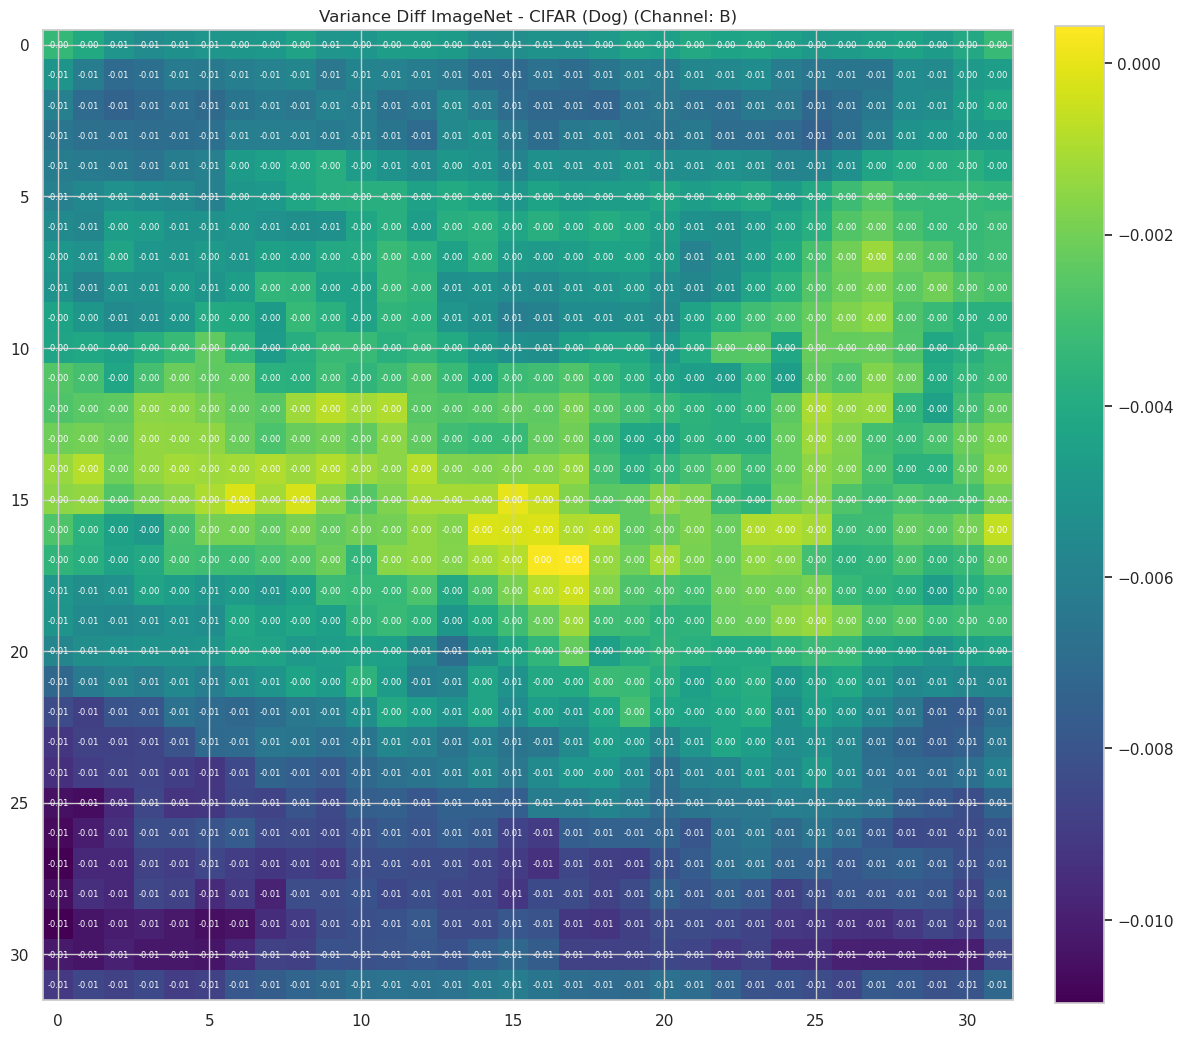

In [12]:
show_number_image(cifar_mean_img, title=f"CIFAR-10 {category} Mean", channel=channel)
show_number_image(imagenet_mean_img, title=f"Imagenet {category} Mean", channel=channel)

show_number_image(cifar_variance_img, title=f"CIFAR-10 {category} Variance", channel=channel)
show_number_image(imagenet_variance_img, title=f"Imagenet {category} Variance", channel=channel)

show_number_image(mean_diff, title="Mean Diff ImageNet - CIFAR (Dog)", channel=channel)
show_number_image(variance_diff, title="Variance Diff ImageNet - CIFAR (Dog)", channel=channel)

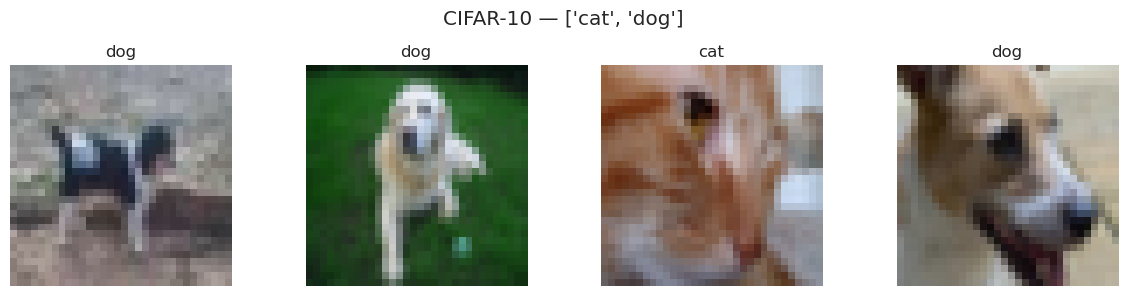

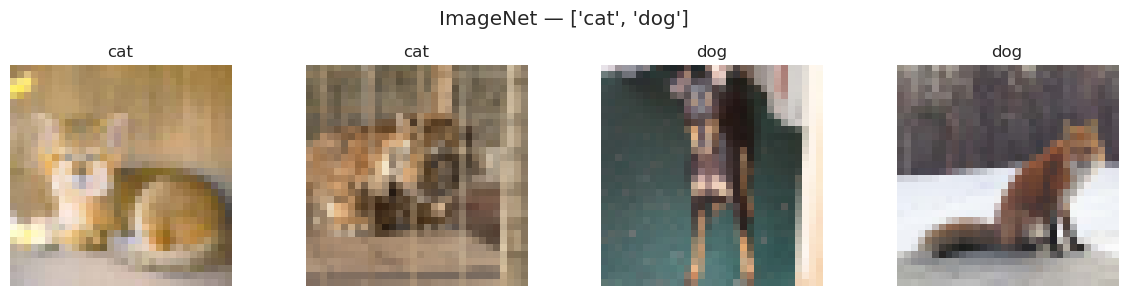

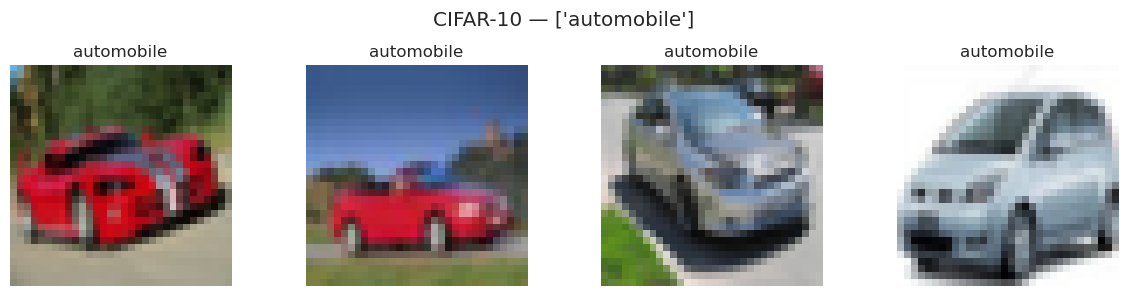

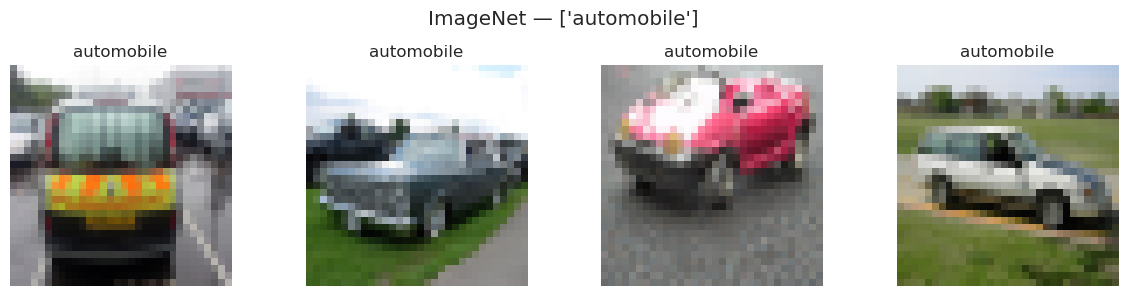

In [13]:
# Show 7 random CIFAR-10 images from ["cat", "dog"]
show_images(df, path_to_cinic10, label="CIFAR-10", n=4, random_state=40, class_filter=["cat", "dog"])

# Show 7 random ImageNet images from ["cat", "dog"]
show_images(df, path_to_cinic10, label="ImageNet", n=4, random_state=40, class_filter=["cat", "dog"])

# Show 7 random CIFAR-10 images from ["automobile"]
show_images(df, path_to_cinic10, label="CIFAR-10", n=4, random_state=50, class_filter= "automobile")

# Show 7 random ImageNet images from ["automobile"]
show_images(df, path_to_cinic10, label="ImageNet", n=4, random_state=50, class_filter= "automobile")

